
# SpherePop Trust Dynamics: A Computational Demonstration of Hysteresis and Entropic Alignment

This notebook implements a minimal dynamical model of **entropic trust coupling** to demonstrate:
- **Bistability** between coherent (high-κ) and fragmented (low-κ) regimes  
- **Hysteresis** as the **precautionary trap** (path dependence)  
- **Basin hopping** via **shocks** (temporary interventions)  
- Sensitivity to **network topology** and **noise**



In [1]:

import numpy as np
import matplotlib.pyplot as plt

# Display settings
np.set_printoptions(precision=3, suppress=True)



## Model Parameters

You can tweak these defaults to explore different regimes.


In [2]:

# === Parameters (feel free to tweak) ===
n = 30                  # number of agents
eta = 1.5               # responsiveness to misalignment
sigma2 = 0.8            # tolerance (squared)
D = 0.05                # noise amplitude
dt = 0.05               # integration step
T = 200                 # steps per gamma value during sweeps
gamma_vals = np.linspace(0.2, 1.5, 150)  # sweep range for gamma

rng = np.random.default_rng(42)



## Graph Topologies and Laplacian

We start with a ring lattice and include an optional **Watts–Strogatz small-world** generator.


In [3]:

def laplacian_from_adjacency(A):
    deg = np.diag(A.sum(axis=1))
    return deg - A

def ring_adjacency(n):
    A = np.zeros((n, n), dtype=float)
    for i in range(n):
        A[i, (i+1) % n] = 1.0
        A[(i+1) % n, i] = 1.0
    return A

def watts_strogatz(n, k=4, p=0.1, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    A = np.zeros((n, n), dtype=float)
    # initial k-regular ring (k even)
    k = max(2, int(k + (k % 2 == 1)))  # ensure even
    for i in range(n):
        for j in range(1, k//2 + 1):
            A[i, (i+j) % n] = 1.0
            A[(i+j) % n, i] = 1.0
    # rewire
    for i in range(n):
        for j in range(1, k//2 + 1):
            if rng.random() < p:
                # remove edge
                A[i, (i+j) % n] = 0.0
                A[(i+j) % n, i] = 0.0
                # add a new random edge
                target = rng.integers(0, n)
                while target == i or A[i, target] == 1.0:
                    target = rng.integers(0, n)
                A[i, target] = 1.0
                A[target, i] = 1.0
    return A



## Dynamics Integrator

One Euler–Maruyama step for \((\Phi,\kappa)\):


In [4]:

def step(phi, kappa, L, gamma, eta, sigma2, D, dt, rng):
    noise = np.sqrt(D * dt) * rng.standard_normal(len(phi))
    phi = phi + (-kappa * (L @ phi)) * dt + noise
    # average pairwise squared difference ~ 2 * variance for mean-field intuition
    grad2 = np.mean((phi[:, None] - phi[None, :]) ** 2)
    kappa_dot = eta * (grad2 - sigma2) - gamma * kappa
    kappa = max(0.0, kappa + kappa_dot * dt)
    return phi, kappa



## Bidirectional γ Sweep (Hysteresis)

We sweep \(\gamma\) up and then down, recording the steady variance of \(\Phi\) and the mean coupling \(\kappa\).


In [5]:

def run_sweep(L, direction='up', shock=False, shock_gamma=0.8, eta=eta, sigma2=sigma2, D=D, dt=dt, T=T, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    phi = rng.standard_normal(L.shape[0])
    kappa = 0.5
    kappas, variances = [], []
    gammas = gamma_vals if direction == 'up' else gamma_vals[::-1]
    for gamma in gammas:
        for _ in range(T):
            phi, kappa = step(phi, kappa, L, gamma, eta, sigma2, D, dt, rng)
        # Optional instantaneous "shock"
        if shock and abs(gamma - shock_gamma) < 1e-3:
            phi = phi * 0.3 + phi.mean() * 0.7  # consensus nudge
            kappa = min(2.0, kappa * 2.5)       # trust boost
        kappas.append(kappa)
        variances.append(np.var(phi))
    return np.array(gammas), np.array(kappas), np.array(variances)


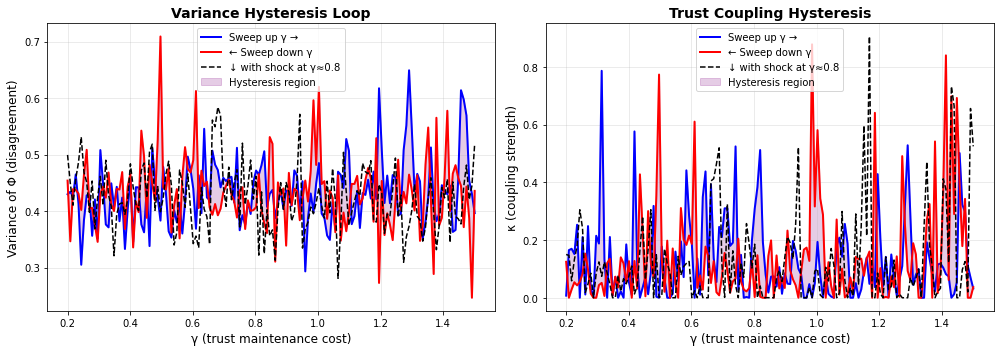

In [6]:

# Choose topology
A = ring_adjacency(n)
# A = watts_strogatz(n, k=4, p=0.1, rng=rng)  # try small-world
L = laplacian_from_adjacency(A)

# Run sweeps
gamma, k_up, v_up = run_sweep(L, 'up', shock=False, rng=rng)
_,     k_dn, v_dn = run_sweep(L, 'down', shock=False, rng=rng)
_,     k_sh, v_sh = run_sweep(L, 'down', shock=True, shock_gamma=0.8, rng=rng)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Variance hysteresis
ax1.plot(gamma, v_up, color='blue', linewidth=2, label='Sweep up γ →')
ax1.plot(gamma, v_dn, color='red', linewidth=2, label='← Sweep down γ')
ax1.plot(gamma, v_sh, color='black', linestyle='--', linewidth=1.5, label='↓ with shock at γ≈0.8')
ax1.fill_between(gamma, v_up, v_dn, alpha=0.2, color='purple', label='Hysteresis region')
ax1.set_xlabel('γ (trust maintenance cost)', fontsize=12)
ax1.set_ylabel('Variance of Φ (disagreement)', fontsize=12)
ax1.set_title('Variance Hysteresis Loop', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Coupling hysteresis
ax2.plot(gamma, k_up, color='blue', linewidth=2, label='Sweep up γ →')
ax2.plot(gamma, k_dn, color='red', linewidth=2, label='← Sweep down γ')
ax2.plot(gamma, k_sh, color='black', linestyle='--', linewidth=1.5, label='↓ with shock at γ≈0.8')
ax2.fill_between(gamma, k_up, k_dn, alpha=0.2, color='purple', label='Hysteresis region')
ax2.set_xlabel('γ (trust maintenance cost)', fontsize=12)
ax2.set_ylabel('κ (coupling strength)', fontsize=12)
ax2.set_title('Trust Coupling Hysteresis', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



## Fixed-γ Bistability (Two Initial Conditions)

At a \(\gamma\) inside the bistable wedge, start once **coherent** and once **fragmented** to reveal two distinct steady states.


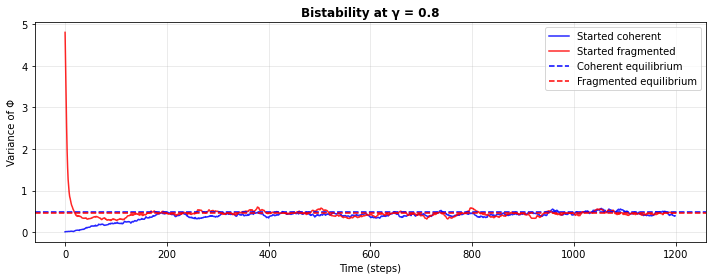

In [7]:

def run_timeseries(L, gamma_fixed=0.8, steps=1200, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    # Two different initializations
    phi_c = 0.1 * rng.standard_normal(L.shape[0])    # near consensus
    phi_f = 2.0 * rng.standard_normal(L.shape[0])    # scattered
    k_c, k_f = 1.2, 0.2
    var_c, var_f = [], []
    for _ in range(steps):
        phi_c, k_c = step(phi_c, k_c, L, gamma_fixed, eta, sigma2, D, dt, rng)
        phi_f, k_f = step(phi_f, k_f, L, gamma_fixed, eta, sigma2, D, dt, rng)
        var_c.append(np.var(phi_c))
        var_f.append(np.var(phi_f))
    return np.array(var_c), np.array(var_f)

var_c, var_f = run_timeseries(L, gamma_fixed=0.8, steps=1200, rng=rng)

plt.figure(figsize=(10,4))
plt.plot(var_c, label='Started coherent', color='blue', alpha=0.85)
plt.plot(var_f, label='Started fragmented', color='red', alpha=0.85)
plt.axhline(np.mean(var_c[-200:]), color='blue', linestyle='--', label='Coherent equilibrium')
plt.axhline(np.mean(var_f[-200:]), color='red', linestyle='--', label='Fragmented equilibrium')
plt.xlabel('Time (steps)'); plt.ylabel('Variance of Φ')
plt.title('Bistability at γ = 0.8', fontweight='bold')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()



## Topology Experiments (Optional)

Uncomment the **Watts–Strogatz** generator above and try different rewiring probabilities \(p\).  
Observe how adding shortcuts (increasing algebraic connectivity \(\lambda_2\)) narrows the hysteresis loop and raises overall stability.



## Discussion

- **Bistability** arises from the **nonlinear feedback** between variance and coupling.  
- **Hysteresis** formalizes the **precautionary trap**: removing the stressor does not restore coherence; a **positive shock** is needed.  
- **Delays** in the \(\kappa\) update (not shown here) generate small **limit cycles** (policy whiplash).  
- **Percolation** perspective clarifies the role of topology: above a connectivity threshold, coherence forms a giant component.

## Conclusion

The minimal system here provides a falsifiable, runnable model of **alignment as thermodynamic equilibrium**.  
It shows how **trust** (modeled as boundary permeability \(\kappa\)) is not a metaphor but a **control parameter** of a nonequilibrium phase transition.
